In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import utils
import config
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import os

/home/oh/owl982/.conda/envs/tda_for_fairness/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_TO_DATA = "../../data/toxigen/"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

annotated_train, annotated_test = utils.prepare_datasets()
tokenizer = AutoTokenizer.from_pretrained(config.TOKENIZER_NAME)
train_dataloader = utils.get_dataloader(annotated_train, tokenizer, config.MAX_LENGTH, config.BATCH_SIZE)
val_dataloader = utils.get_dataloader(annotated_test, tokenizer, config.MAX_LENGTH, config.BATCH_SIZE)

In [4]:
import os
path_to_data="../../data/toxigen/"
os.path.exists(path_to_data + "val.csv")

True

In [3]:
annotated_test.target_group.unique()

array(['black/african-american folks', 'mexican folks', 'women',
       'native american/indigenous folks', 'native american folks',
       'folks with physical disabilities', 'latino/hispanic folks',
       'chinese folks', 'middle eastern folks', 'asian folks',
       'jewish folks', 'muslim folks', 'folks with mental disabilities',
       'lgbtq+ folks'], dtype=object)

In [4]:
wg = "mexican folks"
wg_val_dataloader = utils.get_dataloader(annotated_test.loc[annotated_test["target_group"]==wg], tokenizer, config.MAX_LENGTH, config.BATCH_SIZE)

In [5]:
model_path = "../../output/base_model_finetuning/checkpoint-5600/"
base_model = AutoModelForSequenceClassification.from_pretrained(model_path,num_labels = 2).to(DEVICE)
base_model.to(DEVICE)
base_model.eval()

base_model_acc = utils.compute_accuracy(base_model, val_dataloader, DEVICE)
print(base_model_acc)
base_model_acc_wg = utils.compute_accuracy(base_model, wg_val_dataloader, DEVICE)
print(base_model_acc_wg)

0.8031914893617021
0.7945205479452054


In [6]:
module1_names = ["BM25_finetuning","FAISS_finetuning","random_finetuning"]
k_models = list(range(50,750,50))
#checkpoints = [f"checkpoint-{i}" for i in [60,90,120,150]]
num_models = len(k_models)
#num_checkpoints = len(checkpoints)
colors = ["blue","black","red"]

BM25_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700
FAISS_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700


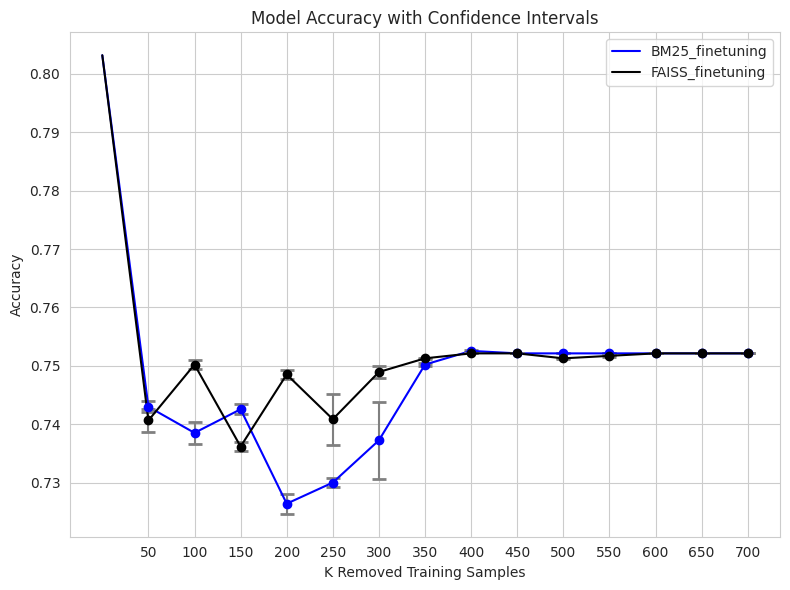

In [8]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")


for module1_name, color in zip(module1_names,colors):
    accuracies = []
    print(module1_name)

    for k_model in k_models:
        print(k_model)
        checkpoints = os.listdir(f"../../output/{module1_name}/{k_model}/")
        num_checkpoints = len(checkpoints)
        model_accuracies = []
        
        for checkpoint in checkpoints[5:]:
            # Load the model
            model_path = f"../../output/{module1_name}/{k_model}/{checkpoint}"
            model = AutoModelForSequenceClassification.from_pretrained(model_path,num_labels = 2).to(DEVICE)
            model.to(DEVICE)
            model.eval()
            
            accuracy = utils.compute_accuracy(model, val_dataloader, DEVICE)
            model_accuracies.append(accuracy)
        
        accuracies.append(model_accuracies)

    # Convert to numpy array for easier manipulation
    accuracies = np.array(accuracies)

    # Compute mean and standard error for each model
    means = np.mean(accuracies, axis=1)
    std_errors = np.std(accuracies, axis=1) / np.sqrt(num_checkpoints)

    # Plotting
    plt.errorbar(k_models, means, yerr=std_errors, fmt='o', capsize=5, capthick=2, ecolor='gray', color = color)
    plt.plot([0]+k_models, np.hstack([base_model_acc,means]), color = color, label = module1_name)

plt.xlabel('K Removed Training Samples')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Confidence Intervals')
plt.xticks(k_models)
plt.legend()

plt.tight_layout()
#plt.savefig('model_accuracies.png')
plt.show()

BM25_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700
FAISS_finetuning
50
100
150
200
250
300
350
400
450
500
550
600
650
700


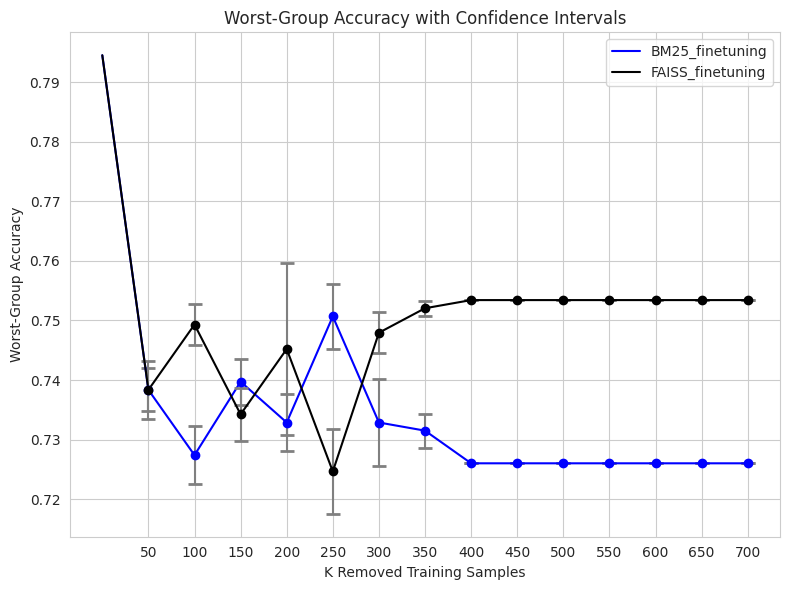

In [12]:
# Worst-Group Accuracies

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

for module1_name,color in zip(module1_names,colors):
    wg_accuracies = []
    print(module1_name)

    for k_model in k_models:
        model_accuracies = []
        checkpoints = os.listdir(f"../../output/{module1_name}/{k_model}/")
        num_checkpoints = len(checkpoints)
        print(k_model)
        
        for checkpoint in checkpoints:
            # Load the model
            model_path = f"../../output/{module1_name}/{k_model}/{checkpoint}"
            model = AutoModelForSequenceClassification.from_pretrained(model_path,num_labels = 2).to(DEVICE)
            model.to(DEVICE)
            
            # Compute accuracy
            accuracy = utils.compute_accuracy(model, wg_val_dataloader, DEVICE)
            model_accuracies.append(accuracy)
        
        wg_accuracies.append(model_accuracies)

    # Convert to numpy array for easier manipulation
    wg_accuracies = np.array(wg_accuracies)

    # Compute mean and standard error for each model
    means = np.mean(wg_accuracies, axis=1)
    std_errors = np.std(wg_accuracies, axis=1) / np.sqrt(num_checkpoints)

    # Plotting

    plt.errorbar(k_models, means, yerr=std_errors, fmt='o', capsize=5, capthick=2, ecolor='gray',color=color)
    plt.plot([0]+k_models, np.hstack([base_model_acc_wg,means]), color=color, label = module1_name)

plt.xlabel('K Removed Training Samples')
plt.ylabel('Worst-Group Accuracy')
plt.title('Worst-Group Accuracy with Confidence Intervals')
plt.xticks(k_models)
plt.legend()

plt.tight_layout()
#plt.savefig('model_accuracies.png')
plt.show()